# Prerequisites

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet50

In [2]:
data_dir = "../data"
val_img_dir = f"{data_dir}/val_images"

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
f"Using device: {device}"

'Using device: cuda'

# Dataset class

In [3]:
class HWSet(Dataset):
    """Dataset class for the Husky vs. Wolf dataset."""

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.val_img_dir = f"{self.data_dir}/val_images"

        all_labels = np.loadtxt(
            f"{self.data_dir}/ILSVRC2012_validation_ground_truth.txt"
        ).astype(int)
        all_img_files = os.listdir(self.val_img_dir)

        self.class_indices = []
        for idx, name in ((3, "siberian husky"), (205, "grey wolf")):
            self.class_indices.append(np.where(all_labels == idx)[0])

        self.labels = []
        for label, indices in enumerate(self.class_indices):
            self.labels = self.labels + indices.size * [label]
        self.labels = np.array(self.labels)

        self.imgs = [
            all_img_files[idx] for indices in self.class_indices for idx in indices
        ]

    def __len__(self):
        return self.labels.size

    def __getitem__(self, item):
        img = Image.open(f"{val_img_dir}/{self.imgs[item]}")

        if self.transform is not None:
            img = self.transform(img)

        return (img, self.labels[item])

## Transforms

In [4]:
transform = transforms.Compose(
    [
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
normalize_inv = transforms.Compose(
    [
        transforms.Normalize(
            mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)
        ),
        transforms.Normalize(mean=(-0.485, -0.456, -0.406), std=(1.0, 1.0, 1.0)),
    ]
)  # For visualization purposes.

## Dataset

In [5]:
dset = HWSet(data_dir, transform=transform)
len(dset)

100

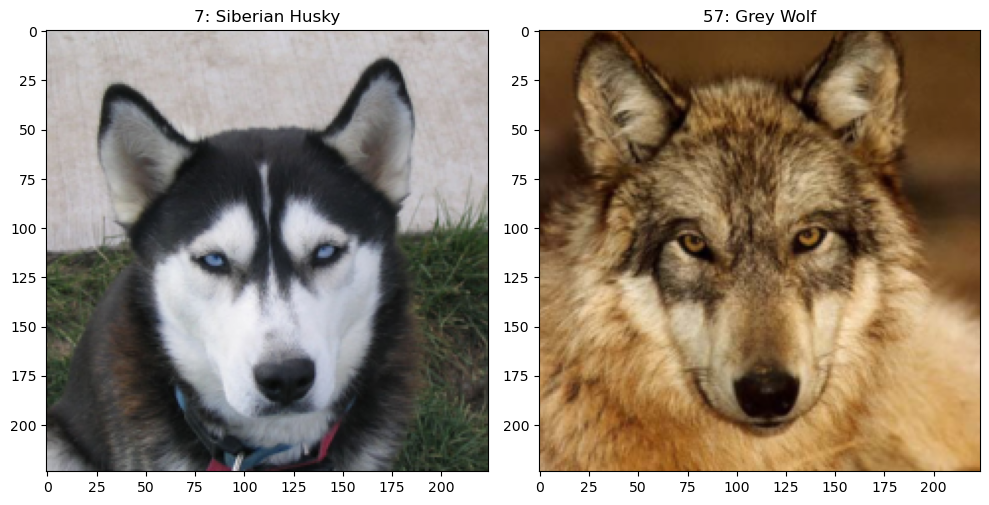

In [6]:
class_legend = ("Siberian Husky", "Grey Wolf")

fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
items = 7, 57

for item, ax in zip(items, axs):
    img, label = dset[item]

    ax.imshow(np.moveaxis(normalize_inv(img).numpy(), 0, -1))
    ax.set_title(f"{item}: {class_legend[label]}");

## Dataloader

In [7]:
dloader = DataLoader(dset, batch_size=1)
img_batch, label_batch = next(iter(dloader))

img_batch.size(), label_batch.size()

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# Load model

In [8]:
model = resnet50(weights='IMAGENET1K_V2')
model.to(device);

# Inference

In [9]:
# Label to class map.
with open(f"{data_dir}/imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

In [10]:
dloader_iter = iter(dloader)

In [11]:
img_batch, label_batch = next(dloader_iter)
with torch.no_grad():
    out = model(img_batch.to(device))
    # print(torch.topk(out.flatten(), 5).indices, label_batch.item())
print(
    f"Predicted (Top 5):\t {[idx2label[idx.cpu().item()].split(', ')[0] for idx in torch.topk(out.flatten(), 5).indices]}\n" +
    f"Ground truth:\t\t {class_legend[label_batch.item()]}" 
)

Predicted (Top 5):	 ['pillow', 'mask', 'swing', 'jersey', 'trench coat']
Ground truth:		 Siberian Husky


# Saliency mapping

In [12]:
# https://github.com/sunnynevarekar/pytorch-saliency-maps/blob/master/Saliency_maps_in_pytorch.ipynb
def saliency(input, model, label):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    # input = transform(img)
    # input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    print(
        f"Predicted (Top 5):\t {[idx2label[idx.cpu().item()].split(', ')[0] for idx in torch.topk(preds.flatten(), 5).indices]}\n" +
        f"Ground truth:\t\t {class_legend[label.item()]}" 
    )
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = normalize_inv(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

Predicted (Top 5):	 ['Siberian husky', 'Eskimo dog', 'malamute', 'Pembroke', 'Norwegian elkhound']
Ground truth:		 Siberian Husky


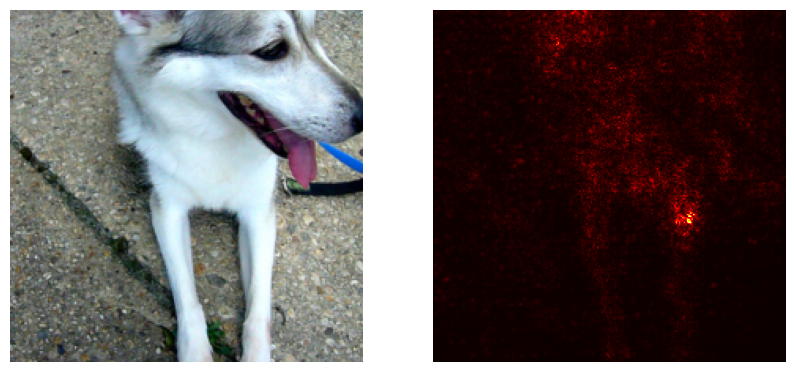

In [13]:
img_batch, label_batch = next(dloader_iter)
saliency(img_batch.to(device), model, label_batch)